In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import h5py
from data_analysis_codes.tools import Ricci_CoGrad_Weyl as RCW_file
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import FD as FD_file
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)
home_path = '/home/robynm/simulations/Geometrical/'
sciama_path = '/mnt/lustre/munozr/runs/Geometrical/'
path = sciama_path
simname = 'BianchiVI'

In [2]:
allNs = [int(np.ceil(i)) for i in np.geomspace(13, 150, 30)]
ic = 6
meanerror_4R = []
meanerror_B2 = []
meanerror_BT = []
meanerror_E2 = []
meanerror_ET = []
for N in allNs:
    L = 20
    dx = L/N
    xyz = np.arange(-L/2, L/2, dx)[:N]
    x, y, z = np.meshgrid(xyz, xyz, xyz, indexing='ij')
    Box_zero = np.zeros([N, N, N])
    Box_ones = np.ones([N, N, N])

    gamma = 1.22
    sign = 1
    s = (2 - gamma)/(2*gamma)
    q = (6-5*gamma)*(2-gamma+2*sign*np.sqrt((9*gamma-1)*(gamma-1)))/(2*gamma*(35*gamma-36))
    k = np.sqrt(-(3*s+3*q-1)/((s+3*q-1)*(3*s*s+(6*q-1)*s-q*q-q)))
    m = np.sqrt(-32*q*q*s/((s-q-1)*(s-q-1)*(3*s+3*q-1)))

    RRead.BASH('mkdir '+path+simname+'_N'+str(N))
    RRead.BASH('mkdir '+path+simname+'_N'+str(N)+'/all_iterations')    
    dtfac = 0.05
    dt = dx*dtfac
    t_array = np.arange(1.5-ic*dt, 1.5+dt, dt)
    for it, t in enumerate(t_array):
        A = k*k*t*t*(1+m*m)*Box_ones
        B = m*k*(t**(1+s-q))*np.exp(x)
        C = (t**(2*(s-q)))*np.exp(2*x)
        D = (t**(2*(s+q)))*np.exp(-2*x)

        gdown = np.array([[A, B, Box_zero],
                          [B, C, Box_zero],
                          [Box_zero, Box_zero, D]])

        Kdown = (-1/2)*np.array([[2*k*k*t*(1+m*m)*Box_ones, (1+s-q)*m*k*(t**(s-q))*np.exp(x), Box_zero],
                                 [(1+s-q)*m*k*(t**(s-q))*np.exp(x), (2*(s-q))*(t**(2*(s-q)-1))*np.exp(2*x), Box_zero],
                                 [Box_zero, Box_zero, (2*(s+q))*(t**(2*(s+q)-1))*np.exp(-2*x)]])
        
        fname = path+simname+'_N'+str(N)+'/all_iterations/'+simname+'_it_{:06d}.hdf5'.format(it)
        with h5py.File(fname, 'w') as fnew:
            fnew['gxx it={}'.format(it)] = gdown[0,0]
            fnew['gxy it={}'.format(it)] = gdown[0,1]
            fnew['gxz it={}'.format(it)] = gdown[0,2]
            fnew['gyy it={}'.format(it)] = gdown[1,1]
            fnew['gyz it={}'.format(it)] = gdown[1,2]
            fnew['gzz it={}'.format(it)] = gdown[2,2]
            fnew['kxx it={}'.format(it)] = Kdown[0,0]
            fnew['kxy it={}'.format(it)] = Kdown[0,1]
            fnew['kxz it={}'.format(it)] = Kdown[0,2]
            fnew['kyy it={}'.format(it)] = Kdown[1,1]
            fnew['kyz it={}'.format(it)] = Kdown[1,2]
            fnew['kzz it={}'.format(it)] = Kdown[2,2]
            
    RRead.BASH("""printf "%s\n" "simname  = '"""+simname+"""'" "N = """+str(N)+"""" "L = """+str(L)+"""" "dtfac = """+str(dtfac)+"""" "boundary = False" "data_path = '"""+path+simname+'_N'+str(N)+"""/'"> data_analysis_codes/EBWeylparam.py""")
    RRead.BASH("python data_analysis_codes/EBWeyl_test.py")
    
    t = 1.5
    it = np.argmin(abs(t_array-t))
    fname = path+simname+'_N'+str(N)+'/EBWeyl/it={:06d}.hdf5'.format(it)
    f = h5py.File(fname, 'r')
    
    RicciS4th = Box_ones*(-4+k*k*(m*m*(1+q-s)*(1+q-s)+4*(q*q+3*s*s)))/(2*k*k*t*t)
    meanerror_4R += [np.mean(np.ma.masked_invalid(abs(np.array(f['RicciS4'])/RicciS4th-1)[ic:-ic,ic:-ic,ic:-ic]))]

    gdetth = k*k*(t**(2+4*s))*Box_ones
    B2th = (9*m*m*(1+q-s)*(1+q-s)+16*(1-s)*(1-s))*abs(gdetth)/(8*(k**4)*(t**(6+4*s)))
    c1 = (1 + q - s)
    c2 = (-1 + s)
    E2th = Box_ones*(16 + 16*k*k*(-2*q*q + m*m*c1*c1) + (k**4)*(16*q*q*(q*q + 3*c2*c2) + m*m*(11*q*q - 18*q*c2 + 3*c2*c2)*c1*c1 + 4*(m**4)*(c1**4)))/(24*((k*t)**4))
    meanerror_E2 += [np.mean(np.ma.masked_invalid(abs(np.array(f['E2'])[ic:-ic,ic:-ic,ic:-ic]/E2th[ic:-ic,ic:-ic,ic:-ic]-1)))]
    meanerror_ET += [np.mean(np.ma.masked_invalid(abs(np.array(f['Etrace'])[ic:-ic,ic:-ic,ic:-ic])))]
    meanerror_B2 += [np.mean(np.ma.masked_invalid(abs(np.array(f['B2'])[ic:-ic,ic:-ic,ic:-ic]/B2th[ic:-ic,ic:-ic,ic:-ic]-1)))]
    meanerror_BT += [np.mean(np.ma.masked_invalid(abs(np.array(f['Btrace'])[ic:-ic,ic:-ic,ic:-ic])))]
    print('N={}, error={:.2e}, {:.2e}, {:.2e}, {:.2e}, {:.2e}'.format(N, meanerror_4R[-1], meanerror_B2[-1], meanerror_BT[-1], meanerror_E2[-1], meanerror_ET[-1]))
    RRead.BASH('rm -rf '+path+simname+'_N'+str(N))

N=13, error=5.04e+03, 1.37e+03, 2.22e-32, 3.04e+06, 2.13e-14
N=15, error=4.23e+02, 1.16e+02, 1.54e-31, 2.12e+04, 1.18e-15
N=16, error=1.57e+02, 4.36e+01, 3.42e-31, 2.93e+03, 6.11e-16
N=17, error=6.67e+01, 1.88e+01, 2.20e-31, 5.45e+02, 1.78e-16
N=19, error=1.70e+01, 4.92e+00, 3.51e-31, 4.20e+01, 7.14e-17
N=20, error=9.86e+00, 2.88e+00, 5.98e-31, 1.64e+01, 4.16e-17
N=22, error=4.00e+00, 1.19e+00, 2.90e-30, 4.10e+00, 2.78e-17
N=24, error=1.93e+00, 5.79e-01, 2.20e-30, 1.55e+00, 2.95e-17
N=26, error=1.04e+00, 3.15e-01, 1.32e-29, 7.40e-01, 3.52e-17
N=28, error=6.09e-01, 1.84e-01, 1.26e-29, 4.04e-01, 2.95e-17
N=31, error=3.00e-01, 9.12e-02, 1.53e-29, 1.90e-01, 2.67e-17
N=33, error=1.97e-01, 5.99e-02, 2.95e-29, 1.22e-01, 3.04e-17
N=36, error=1.11e-01, 3.37e-02, 2.53e-29, 6.79e-02, 2.05e-17
N=39, error=6.60e-02, 2.01e-02, 1.42e-28, 4.01e-02, 2.70e-17
N=43, error=3.53e-02, 1.08e-02, 7.93e-29, 2.14e-02, 3.02e-17
N=47, error=2.01e-02, 6.13e-03, 1.09e-28, 1.21e-02, 2.80e-17
N=51, error=1.21e-02, 3.

<IPython.core.display.Javascript object>


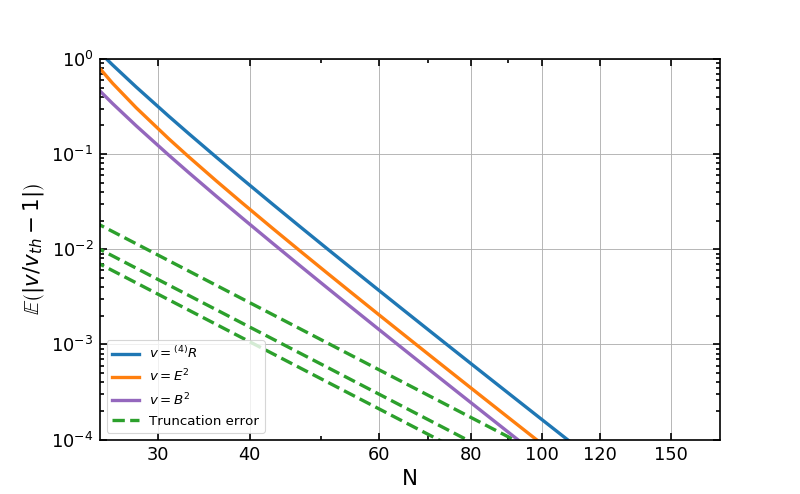

In [3]:
idec = -1

phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))

plt.loglog(allNs, meanerror_4R, 'C0', label=r'$v={}^{(4)}R$')
yplot_4th_order_decrease = [meanerror_4R[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--')

plt.loglog(allNs, meanerror_E2, 'C1', label=r'$v=E^2$')
yplot_4th_order_decrease = [meanerror_E2[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--')

plt.loglog(allNs, meanerror_B2, 'C4', label=r'$v=B^2$')
yplot_4th_order_decrease = [meanerror_B2[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', label='Truncation error')

plt.legend(loc=3, prop={'size': 12})
plt.grid()
plt.xlabel('N')
plt.ylim(1e-4, 1)
plt.xticks([30,40,60,80,100,120,150], ['30','40','60','80','100','120', '150'])
plt.xlim(25, 175)
plt.ylabel(r'$\mathbb{E}\left(|v/v_{th}-1|\right)$')
#plt.savefig('./Plots/BianchiVI_Geometric.pdf')

In [3]:
import pandas as pd
data = np.array([allNs, meanerror_4R, meanerror_B2, meanerror_BT, meanerror_E2, meanerror_ET]).T
columns = ['N', '4R', 'B2', 'BT', 'E2', 'ET']
pd.DataFrame(data, columns=columns).to_csv('ErrorData/BianchiVI_Geometric_o6R.csv')